### 1. Разбиваем файл с твитами на тренировочную, валидационную и тестовую выборки

In [1]:
from src.data_utils import process_text

process_text('./data/')

Обработка текста...


100%|██████████| 1600498/1600498 [00:10<00:00, 155889.29it/s]



Перемешиваем данные...
Размер тренировочного набора: 1280398 ( 80.0%)
Размер валидационного набора: 160050 ( 10.0%)
Размер тестового набора: 160050 ( 10.0%)

Сохраняем разделенные датасеты...
Тренировочный набор сохранен в: ./data/train.csv
Валидационный набор сохранен в: ./data/val.csv
Тестовый набор сохранен в: ./data/test.csv


### 2. Тренируем собственную модель

Для начала импортируем все необходимые модули

In [3]:
import os
import random

import pandas as pd
import torch
from transformers import AutoTokenizer

from src.data_utils import split_text_3_4
from src.eval_lstm import generate_and_evaluate
from src.lstm_model import SimpleLSTM
from src.lstm_train import train_model_with_rouge
from src.next_token_dataset import create_dataloader


Загрузим датасеты и создадим даталоадеры

In [ ]:
data_dir = './data/'

# Создаем директорию для чекпоинтов
save_directory = "models"
os.makedirs(save_directory, exist_ok=True)

# Загружаем токенизатор
print('Загрузка токенизатора...')
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Добавляем специальные токены для начала/конца
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print('Загрузка тренировочного датасета...')
train_data = pd.read_csv(f'{data_dir}train.csv')
train_texts = (
    train_data['tweet'] if 'tweet' in train_data.columns
    else train_data.iloc[:, 0]
)

print('Загрузка валидационного датасета...')
val_data = pd.read_csv(f'{data_dir}val.csv')
val_texts = (
    val_data['tweet'] if 'tweet' in val_data.columns
    else val_data.iloc[:, 0]
)

print('Загрузка тестового датасета...')
test_data = pd.read_csv(f'{data_dir}test.csv')
texts = test_data['tweet'].dropna().tolist()
selected_texts = random.sample(texts, 10)

# Создаем Dataloader'ы
print('Создание даталоадеров...')
train_dataloader = create_dataloader(train_texts, tokenizer)
val_dataloader = create_dataloader(val_texts, tokenizer)

Загрузка токенизатора...
Загрузка тренировочного датасета...
Загрузка валидационного датасета...
Загрузка тестового датасета...
Создание даталоадеров...
Количество батчей в dataloader: 5002

Пример батча:
input_ids shape: torch.Size([256, 38])
attention_mask shape: torch.Size([256, 38])
labels shape: torch.Size([256, 38])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: are you cool enough to tie dye your own candles while they re burning cause i am ps soc has too many vocab words starting w
Цель: you cool enough to tie dye your own candles while they re burning cause i am ps soc has too many vocab words starting w s

Элемент 1: 
Вход: followers here we come to
Цель: here we come to go
Количество батчей в dataloader: 626

Пример батча:
input_ids shape: torch.Size([256, 36])
attention_mask shape: torch.Size([256, 36])
labels shape: torch.Size([256, 36])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: yourstrulyjulez http twitpic com pvlg aww cute haha thanks bit

Из выводимых выше данных видно, что даталоадер построен на том, что входные токены для обучения модели и их референсы сдвинуты относительно друг друга на один токен. В процессе обучения будут периодически накапливаться метрики ROUGE посчитанные именно на сравнении двух этих соответственно сдвинутых последовательностей. Поэтому результат будет достаточно высок. Но это даст представление об улучшении качества обучения модели с каждой эпохой.


Запустим процесс обучения модели с периодическим измерением метрик на валидационной выборке (после каждой эпохи) и сохранением показателей в память TrainHistory для постраения графиков.

In [5]:
# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Создаем модель
vocab_size = len(tokenizer)
model = SimpleLSTM(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2
)

print(f"\nМодель создана:")
print(f"  Параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Размер словаря: {vocab_size}")

# Обучаем модель
trained_model, history = train_model_with_rouge(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    selected_texts=selected_texts,
    tokenizer=tokenizer,
    device=device,
    num_epochs=5,
    learning_rate=0.001,
    eval_every=50,  # Каждые 50 шагов
    save_dir=save_directory,
)


Используемое устройство: cpu

Модель создана:
  Параметров: 12,672,570
  Размер словаря: 30522
Начинаем обучение на cpu...
Размер словаря: 30522


Epoch 1/5 [Train]: 100%|██████████| 5002/5002 [4:16:19<00:00,  3.07s/it, loss=5.0814, avg_loss=10.4112, lr=0.001000] 



Epoch 1/5 завершена



Train Loss: 5.7755
Val Loss: 5.2482
Val ROUGE-1: 0.204
Val ROUGE-2: 0.032
Val ROUGE-L: 0.187


  Примеры генерации:
    'I love' -> 'i lovea i m so excited about the new moon trailer is a good thing i m going to miss the'
    'The weather is' -> 'the weather ising i m not sure i m going to be a long day of the day and i m going'
    'Machine learning' -> 'machine learnings and i m not going to the beach with the best friend ever i m so excited about the'



Epoch 2/5 [Train]: 100%|██████████| 5002/5002 [4:14:41<00:00,  3.06s/it, loss=4.8924, avg_loss=9.1931, lr=0.001000]  



Epoch 2/5 завершена



Train Loss: 5.0997
Val Loss: 5.0316
Val ROUGE-1: 0.218
Val ROUGE-2: 0.037
Val ROUGE-L: 0.200


  Примеры генерации:
    'I love' -> 'i lovea and i m not going to the beach with my best friend and i m not going to the'
    'The weather is' -> 'the weather isly hot weather and i m not going to the beach today i m going to miss my friends and'
    'Machine learning' -> 'machine learnings and i m not going to the beach with my best friend and i m not going to the'



Epoch 3/5 [Train]: 100%|██████████| 5002/5002 [4:07:09<00:00,  2.96s/it, loss=5.1123, avg_loss=8.8840, lr=0.001000]  



Epoch 3/5 завершена



Train Loss: 4.9283
Val Loss: 4.9400
Val ROUGE-1: 0.224
Val ROUGE-2: 0.039
Val ROUGE-L: 0.206


  Примеры генерации:
    'I love' -> 'i lovea and i m not sure what i m doing today i m so tired i m so tired i'
    'The weather is' -> 'the weather isly hot weather in the sun with a friend and i m not sure what to do with my life'
    'Machine learning' -> 'machine learnings are the best of the day is the best day ever i m so sorry i missed the last'



Epoch 4/5 [Train]: 100%|██████████| 5002/5002 [4:10:18<00:00,  3.00s/it, loss=4.9551, avg_loss=8.7119, lr=0.001000]  



Epoch 4/5 завершена



Train Loss: 4.8328
Val Loss: 4.8876
Val ROUGE-1: 0.229
Val ROUGE-2: 0.041
Val ROUGE-L: 0.210


  Примеры генерации:
    'I love' -> 'i lovea and i m not sure what i m doing today i m so tired i m so tired i'
    'The weather is' -> 'the weather isous and i m not sure what to do with my new haircut and i m not sure what'
    'Machine learning' -> 'machine learnings is the best thing ever i m not sure what i m doing today i m so tired i'



Epoch 5/5 [Train]: 100%|██████████| 5002/5002 [4:11:44<00:00,  3.02s/it, loss=4.8996, avg_loss=8.5958, lr=0.001000]  



Epoch 5/5 завершена



Train Loss: 4.7684
Val Loss: 4.8547
Val ROUGE-1: 0.232
Val ROUGE-2: 0.042
Val ROUGE-L: 0.213


  Примеры генерации:
    'I love' -> 'i lovea s new album is a new song for the new moon trailer is awesome i m so sorry for'
    'The weather is' -> 'the weather isa and i m not going to the gym today i m going to be in the sun and i'
    'Machine learning' -> 'machine learnings is a good idea for the new moon trailer is awesome i m so sorry for the loss of'



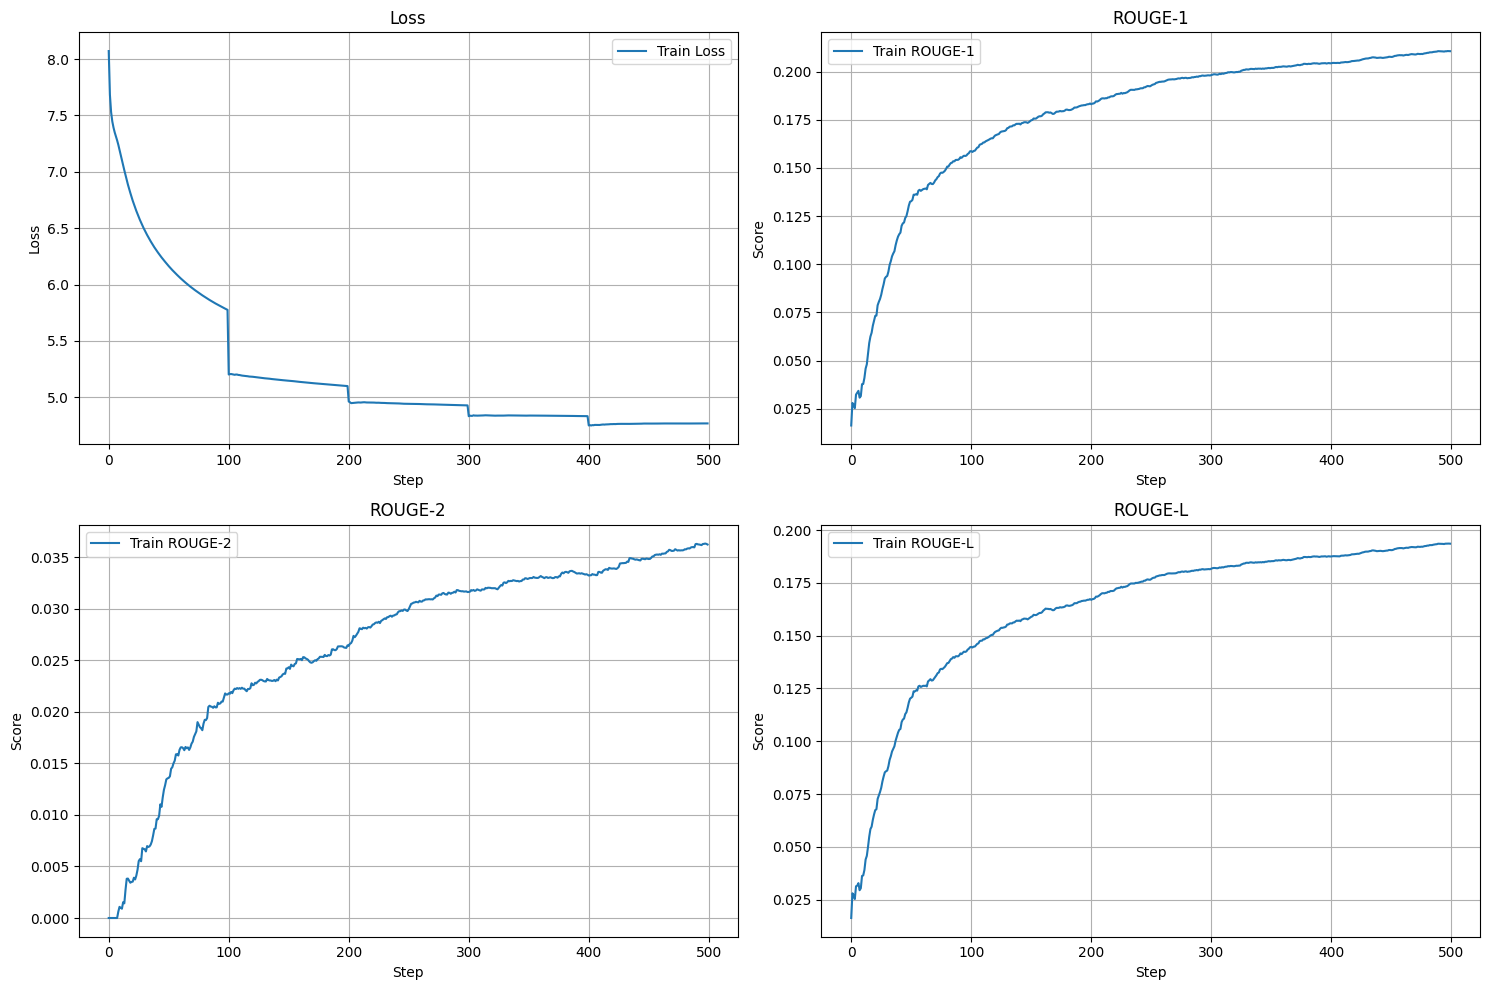

In [6]:
# Визуализируем историю обучения
history.plot_training_history()


Как видно из истории обучения функция потерь с каждой эпохой обучения падает, соответственно модель обучается правильно.

In [7]:
# Финальная оценка
print("\n" + "=" * 60)
print("Финальная оценка модели:")
print("=" * 60)

prompts = []
references = []
for text in selected_texts:
    split_data = split_text_3_4(text, tokenizer)
    prompts.append(split_data['prompt'])
    references.append(split_data['target'])

results = generate_and_evaluate(
    model, tokenizer, prompts, references, device,
)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Финальная оценка модели:


Генерация текста: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


'nmyers it is possible but i still don t' -> 'nmyers it is possible but i still don t ##e to me i m so'
'xbobertx i am too i d totally take you' -> 'xbobertx i am too i d totally take you to the airport i m so'
'redmummy oh no how' -> 'redmummy oh no how ##a is a good friend i'
'haha litwinius ramdass emilytrumble headfights tunuui' -> 'haha litwinius ramdass emilytrumble headfights tunuui ##a http bit ly'
'can someone tell me what the jonas brothers announced it didn t' -> 'can someone tell me what the jonas brothers announced it didn t ##e to me i m so'
'i dont want to be awake i called my dad to tell him happy fathers day but he was' -> 'i dont want to be awake i called my dad to tell him happy fathers day but he was ##a and i was in the hospital i m'
'radio t bad requestyour browser sent a request that this' -> 'radio t bad requestyour browser sent a request that this ##a is not working for me'
'awesome service just got the showed' -> 'awesome service just got the showed ##a s new 

При окончательной оценки качества обученной модели можно сделать вывод о том, что видны осмысленные дополнения входных последовательностей текста.

Измерение метрик ROUGE в данной финальной оценке построено на сравнении окончательных последовательностей на выходе обученной модели c их эталонами, не учитывая входную последовательность. Поэтому метрики ROUGE немного ниже, чем измеренные в процессе обучения. Также они не совсем подходят для оценки качества модели автодополнения текста, а скорее для оценки моделей суммаризации текста. Такие же невысокие показатели метрик видны при замерах на генерации текста с помощью предобученного трансформера `distilgpt2`.

In [5]:
import random

import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.data_utils import split_text_3_4
from src.eval_lstm import generate_and_evaluate

model_name = 'distilgpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForCausalLM.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Загрузка тестового датасета...')
test_data = pd.read_csv('./data/test.csv')
texts = test_data['tweet'].dropna().tolist()
selected_texts = random.sample(texts, 10)

prompts = []
references = []
for text in selected_texts:
    split_data = split_text_3_4(text, tokenizer)
    prompts.append(split_data['prompt'])
    references.append(split_data['target'])

results = generate_and_evaluate(model, tokenizer, prompts, references, device)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Загрузка тестового датасета...


Генерация текста: 100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


'joeymcintyre yeah but if your dad s accent is like yours then it was quot' -> 'joeymcintyre yeah but if your dad s accent is like yours then it was quot able. I don't know what he thinks'
'cameo nope didnt' -> 'cameo nope didnt  do that'
'kevinallensays it s a pretty useless piece of shit now we' -> 'kevinallensays it s a pretty useless piece of shit now we 've got the whole'
'tooory mine hurts because of' -> 'tooory mine hurts because of  the fact'
'jonasbrothers whohoo get pumped' -> 'jonasbrothers whohoo get pumped  about the new season'
'rene kaiser not sure if my stomach will be happy' -> 'rene kaiser not sure if my stomach will be happy  and I just don'
'good morning just got up thought id come tweet' -> 'good morning just got up thought id come tweet , he's'
'does not miss caffeine but does miss' -> 'does not miss caffeine but does miss  it.
'
'i have been editing tee s reel all night and didn t save somethings' -> 'i have been editing tee s reel all night and didn t save somet

## Вывод

Для задач автодополнения текста лучше использовать предобученный трансформер, т.к.:
- лучше благодаря предобучению на огромной выборке текстов, контекста и сложных языковых паттернов;
- требует лишь тонкой настройки на специфичных данных;
- эффективно обрабатывает длинные контексты.

Однако LSTM имеет смысл использовать, если:
- использовать на текстах с уникальной структурой, например, медицинские рецепты;
- ограничения на размер модели и скорость работы;
- нет доступа к GPU.
